In [1]:
# Imports and functions
%matplotlib inline
from matplotlib.colors import LogNorm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,Input, Flatten
from keras import models
from keras import optimizers
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
nuc_arr = ['A','C','G','T']
#Function for calculating modified probability of splicing at SD1
def prob_SD1 (sd1_freq, sd2_freq): 
    if (sd1_freq==0 and sd2_freq==0):
        return 0.0 
    else:
        return sd1_freq/(sd1_freq+sd2_freq)
#Function converting nucleotide sequence to numerical array with 4 channels
def seq_to_arr (seq):
    seq_len = len(seq)
    arr_rep = np.zeros((seq_len, len(nuc_arr))) 
    for i in range(seq_len):
        arr_rep[i][nuc_arr.index(seq[i])] = 1 
    return arr_rep

Using TensorFlow backend.


In [3]:
#Creating a modified dataset with only the necessary information
#Storing model inputs and outputs
reads_path = 'GSM1911086_A5SS_spliced_reads.txt'
seq_path = 'GSM1911085_A5SS_seq.txt'
s1_indx = 1
s2_indx= 45
seq_len = 101
read_lines = []
seq_lines = []
data_table = []
with open(reads_path) as f:
    f.readline() 
    for line in f:
        mod_line = line.split('\t')
        read_lines.append([mod_line[0], mod_line[s1_indx], mod_line[s2_indx]])
with open(seq_path) as f:
    f.readline() 
    for line in f:
        mod_line = line.split('\t') 
        seq_lines.append([mod_line[0], mod_line[1][:-1]])
        
n = len(read_lines)
prob_s1 = np.zeros(n)
inputs = np.zeros((n,seq_len, 4))

with open('5SS_compressed.txt', 'w') as f: 
    for i in range(n):
        data_table.append([read_lines[i][0], seq_lines[i][1], read_lines[i][1], read_lines[i][2]])
        f.write(read_lines[i][0]+'\t'+seq_lines[i][1]+'\t'+read_lines[i][1]+ '\t'+read_lines[i][2] + '\n')
        prob_s1[i] = prob_SD1(float(read_lines[i][1]), float(read_lines[i][2]))
        inputs[i] = seq_to_arr(seq_lines[i][1])

In [7]:
#Creating, training, and testing model_1 (1D), which achieves r2 around 0.71 on test data
#Architecture 1: Input -> Conv -> Pool -> Conv -> Pool -> FC -> FC
model_1 = models.Sequential([
    Conv1D(seq_len,(4), strides=1, input_shape=(seq_len,len(nuc_arr)), activation='relu'),
    MaxPooling1D(pool_size=3),
    Conv1D(seq_len//2, (4), strides=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
#Compiling and training
model_1.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_error')
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(inputs, prob_s1,test_size=0.1, random_state=40) 
model_1.fit(x=X_train_1, y=y_train_1, epochs=5) 
#Testing
y_pred_1 = model_1.predict(X_test_1) 
print("Model 1 r2 on Testing Data:") 
print(r2_score(y_test_1, y_pred_1))

Epoch 1/5
238623/238623 [==============================] - 40s 169us/step - loss: 0.0549
Epoch 2/5
238623/238623 [==============================] - 39s 163us/step - loss: 0.0465
Epoch 3/5
238623/238623 [==============================] - 38s 160us/step - loss: 0.0429
Epoch 4/5
238623/238623 [==============================] - 38s 161us/step - loss: 0.0414
Epoch 5/5
238623/238623 [==============================] - 40s 166us/step - loss: 0.0405
Model 1 r2 on Testing Data:
0.7109766605606966


In [8]:
#Creating, training, and testing model_2, a slightly deeper network (1D); achieves r2 around 0.72 on test data
#Architecture 2: Input -> Conv -> Conv -> Pool -> Conv -> Conv -> Pool -> FC -> FC
model_2 = models.Sequential([
    Conv1D(seq_len,(4), input_shape=(seq_len,len(nuc_arr)), activation='relu'),
    Conv1D(seq_len,(4), input_shape=(seq_len,len(nuc_arr)), activation='relu'),
    MaxPooling1D(pool_size=5),
    Conv1D(seq_len//2,(4), input_shape=(seq_len,len(nuc_arr)), activation='relu'),
    Conv1D(seq_len//2,(4), input_shape=(seq_len,len(nuc_arr)), activation='relu'),
    MaxPooling1D(pool_size=5),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(1)
])
#Compiling and training
model_2.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_error')
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(inputs, prob_s1,test_size=0.1, random_state=40) 
model_2.fit(x=X_train_2, y=y_train_2, epochs=5) 
#Testing
y_pred_2 = model_2.predict(X_test_2) 
print("Model 2 r2 on Testing Data:") 
print(r2_score(y_test_2, y_pred_2))

Epoch 1/5
238623/238623 [==============================] - 62s 260us/step - loss: 0.0513
Epoch 2/5
238623/238623 [==============================] - 62s 261us/step - loss: 0.0421
Epoch 3/5
238623/238623 [==============================] - 60s 251us/step - loss: 0.0401
Epoch 4/5
238623/238623 [==============================] - 61s 255us/step - loss: 0.0387
Epoch 5/5
238623/238623 [==============================] - 62s 261us/step - loss: 0.0379
Model 2 r2 on Testing Data:
0.7216969017557868


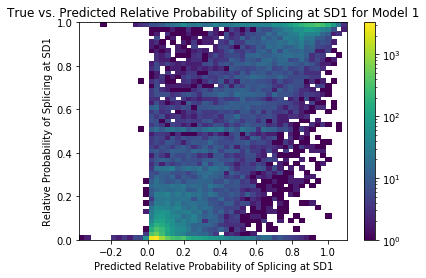

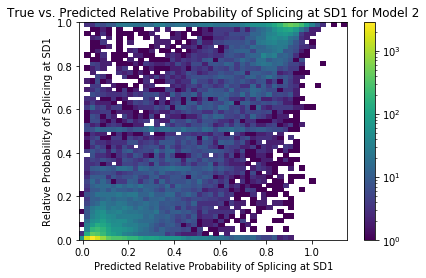

In [9]:
def graph_predictions(prob, pred_prob, mod_name):
    plt.hist2d(pred_prob, prob, bins = 50, norm=LogNorm())
    plt.colorbar()
    plt.title('True vs. Predicted Relative Probability of Splicing at SD1 for '+ mod_name)
    plt.xlabel('Predicted Relative Probability of Splicing at SD1')
    plt.ylabel('Relative Probability of Splicing at SD1')
    plt.show()
graph_predictions(np.array(y_test_1).flatten(), np.array(y_pred_1).flatten(), 'Model 1')
graph_predictions(np.array(y_test_2).flatten(), np.array(y_pred_2).flatten(), 'Model 2')

In [15]:
#10-fold Cross Validation for Model 1
#Architecture 1: Input -> Conv -> Pool -> Conv -> Pool -> FC -> FC

kf = KFold(n_splits=10, shuffle=True)
X = inputs
kf.get_n_splits(X)
y = prob_s1
#10-fold cross validation loop
loop_number = 0
all_accuracies = []
for train_index, test_index in kf.split(X):
    loop_number += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_1.fit(x=X_train, y=y_train, epochs=5) 
    #Testing
    y_pred = model_1.predict(X_test) 
    #print("Model 1 r2 on Testing Data, Fold " + str(loop_number) + ":") 
    all_accuracies.append(r2_score(y_test, y_pred))
    #print(all_accuracies[loop_number-1])

all_accuracies = [0.7116553961798876,0.7183874317313519,0.728985841137145,0.7340356728434496,0.7378579049489997,0.7308530071474002,
                 0.7507839120302571,0.7332371448545114,0.7557610533025598,0.7553410974480715]
print("All 10 Individual Accuracies: " + str(all_accuracies))
print("Model 1 Average r2 10-fold CV: " + str(sum(all_accuracies)/len(all_accuracies)))

All 10 Individual Accuracies: [0.7116553961798876, 0.7183874317313519, 0.728985841137145, 0.7340356728434496, 0.7378579049489997, 0.7308530071474002, 0.7507839120302571, 0.7332371448545114, 0.7557610533025598, 0.7553410974480715]
Model 1 Average r2 10-fold CV: 0.7356898461623633


In [16]:
#10-fold Cross Validation for Model 2
#Architecture 2: Input -> Conv -> Conv -> Pool -> Conv -> Conv -> Pool -> FC -> FC

#10-fold cross validation loop
loop_number = 0
all_accuracies = []
for train_index, test_index in kf.split(X):
    loop_number += 1
    print("Performing fold number " + str(loop_number))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_2.fit(x=X_train, y=y_train, epochs=5) 
    #Testing
    y_pred_2 = model_2.predict(X_test) 
    all_accuracies.append(r2_score(y_test, y_pred_2))

print("All 10 Individual Accuracies: " + str(all_accuracies))
print("Model 2 Average r2 10-fold CV: " + str(sum(all_accuracies)/len(all_accuracies)))

Performing fold number 1
Epoch 1/5
238623/238623 [==============================] - 70s 295us/step - loss: 0.0522
Epoch 2/5
238623/238623 [==============================] - 69s 289us/step - loss: 0.0424
Epoch 3/5
238623/238623 [==============================] - 69s 287us/step - loss: 0.0400
Epoch 4/5
238623/238623 [==============================] - 68s 287us/step - loss: 0.0388
Epoch 5/5
238623/238623 [==============================] - 68s 286us/step - loss: 0.0379
Performing fold number 2
Epoch 1/5
238623/238623 [==============================] - 69s 290us/step - loss: 0.0374
Epoch 2/5
238623/238623 [==============================] - 68s 287us/step - loss: 0.0367
Epoch 3/5
238623/238623 [==============================] - 68s 285us/step - loss: 0.0362
Epoch 4/5
238623/238623 [==============================] - 68s 286us/step - loss: 0.0356
Epoch 5/5
238623/238623 [==============================] - 70s 291us/step - loss: 0.0352
Performing fold number 3
Epoch 1/5
238623/238623 [==========